In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [103]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

def clean_data(data):
    data.columns=column_names

    le = LabelEncoder()
    for pred in categorical_predictors:
        data[pred] = le.fit_transform(data[pred])
    
    data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)

    initial_rows = data.shape[0]

    # Replace all '?' with NaN
    data.replace(' ?', np.nan, inplace=True)
    data.replace('?', np.nan, inplace=True)

    # Drop all rows with NaN
    data.dropna(inplace=True)

    # Drop inst_weight
    data.drop('inst_weight', axis=1, inplace=True)

    print(f"Dropped {initial_rows - data.shape[0]} rows with NaN values")

    return data


In [104]:
def get_metrics(y_test, y_pred):
    print("confusion_matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix, showing the values in each cell
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    # Show the values
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, str(cm[x,y]), va='center', ha='center')

    # Set axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100}%")
    

In [105]:
def find_threshold(y_pred, y_true):
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1])

    # Plot the model precision-recall curve

    df = pd.DataFrame({'Precision': p[:-1], 'Recall': r[:-1], 'Threshold': thresholds})

    # df.set_index('Threshold', inplace=True)

    # USe f1 to find thresh
    threshold = df.iloc[f1.argmax()]['Threshold']

    df.plot(x="Threshold", y=["Precision", "Recall"], figsize=(10, 5), grid=True)
    # Add a vertical line at the threshold that maximizes F1 score
    plt.vlines(threshold, 0, 1, linestyle='--')

    return threshold


In [106]:
data = pd.read_csv('../census-income.data',header=None)

data = clean_data(data)

data.head(2)

Dropped 0 rows with NaN values


,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income,>50K
0,73,3,0,0,12,0,2,6,14,6,...,40,40,4,0,1,2,0,1,- 50000.,0
1,58,6,4,34,16,0,2,0,4,8,...,40,40,4,0,1,2,52,0,- 50000.,0


In [107]:
X = data[predictors]
y = data['>50K']

In [108]:
#import and prepare test data
test = pd.read_csv('../census-income.test',header=None)
test = clean_data(test)

Dropped 0 rows with NaN values


In [109]:
X_test = test[predictors]
y_test = test['>50K']

In [11]:
# Create a basic AdaBoost classifier to see what can be done without tuning
clf = AdaBoostClassifier(n_estimators=500, learning_rate=1, random_state=0)
clf.fit(X, y)


AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=0)

In [12]:
y_pred_proba_train = clf.predict_proba(X)[:, 1]

0.49956268705873547

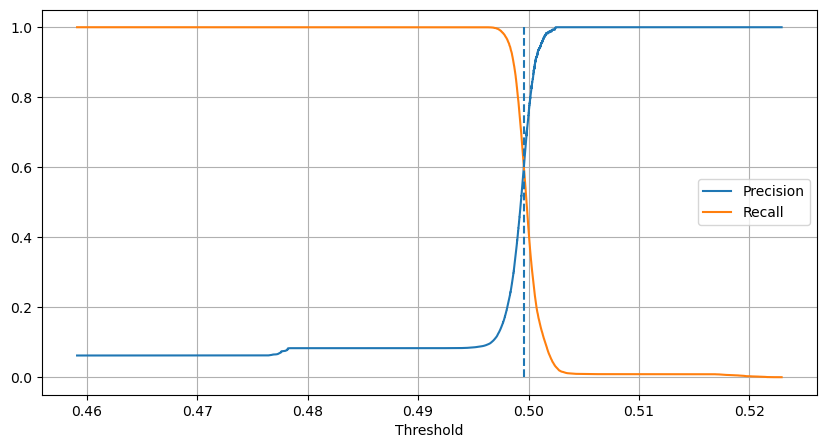

In [13]:
threshold = find_threshold(y_pred_proba_train, y)
threshold

confusion_matrix:
Accuracy: 88.71514203805056%
Recall: 86.50177820885871%
Precision: 33.922911119563835%


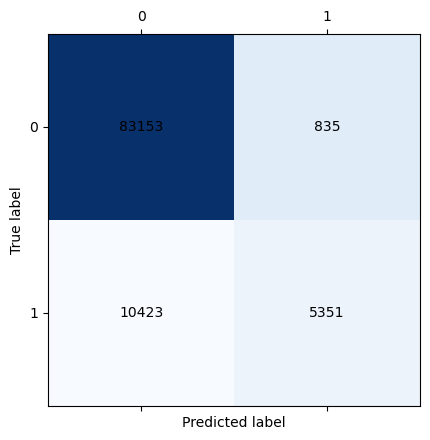

In [18]:
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
threshold = 0.4988
y_pred = (y_pred_proba_test > threshold).astype(int)

get_metrics(y_test, y_pred)

In [88]:
clf_random.best_params_

{'n_estimators': 366,
 'learning_rate': 0.5,
 'estimator': DecisionTreeClassifier(max_depth=2)}

In [105]:
tuned_clf2 = AdaBoostClassifier(n_estimators=515, learning_rate=1, estimator=DecisionTreeClassifier(max_depth=5))

tuned_clf2.fit(X, y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=1, n_estimators=515)

0.49748743718592964

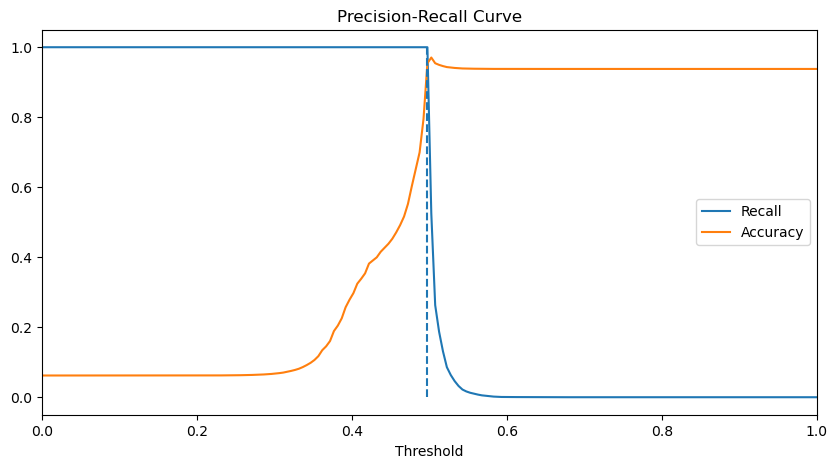

In [140]:
tuned_clf2_proba_train = tuned_clf2.predict_proba(X)[:, 1]

threshold_2 = find_threshold(tuned_clf2_proba_train, y)

tuned_clf2_proba_test = tuned_clf2.predict_proba(X_test)[:, 1]
tuned_clf2_pred = (tuned_clf2_proba_test > threshold_2).astype(int)

threshold_2

In [141]:
get_metrics(y_test, tuned_clf2_pred)

confusion_matrix:
[[87810  5766]
 [ 2484  3702]]
Accuracy: 91.73031815721417%
Recall: 59.84481086323957%


0.4950936130101631

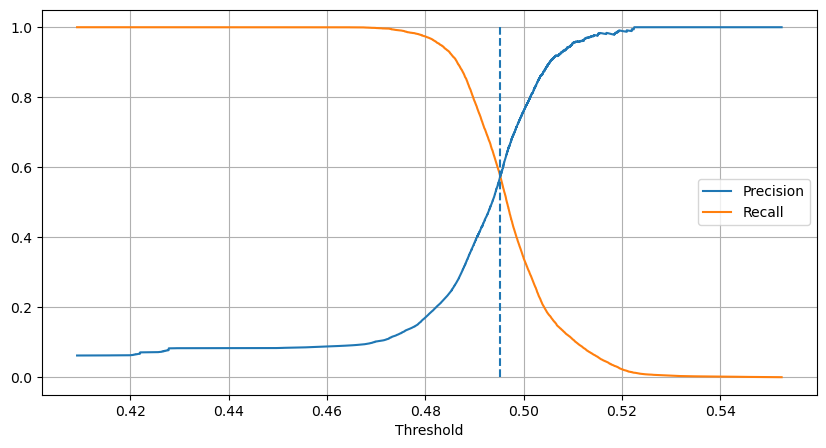

In [30]:
best_ada_v2 = AdaBoostClassifier(n_estimators=1000, 
                                 learning_rate=0.05, 
                                 estimator=DecisionTreeClassifier(max_depth=1, 
                                                                  min_samples_leaf=6),
                                 random_state=42)

best_ada_v2.fit(X, y)

best_ada_v2_proba_train = best_ada_v2.predict_proba(X)[:, 1]

threshold_3 = find_threshold(best_ada_v2_proba_train, y)

threshold_3

In [49]:
y_pred_proba_test = best_ada_v2.predict_proba(X_test)[:, 1]

confusion_matrix:
Accuracy: 89.98215753493314%
Recall: 80.89233753637245%
Precision: 36.21887666473654%


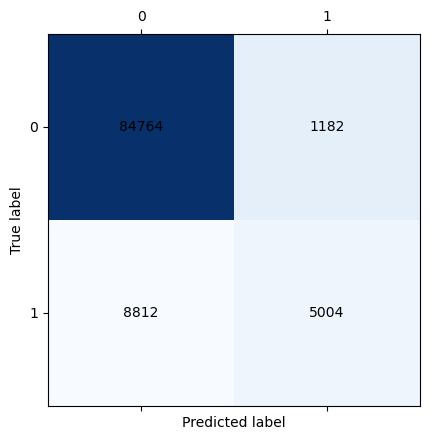

In [39]:
y_pred = (y_pred_proba_test > 0.488).astype(int)

get_metrics(y_test, y_pred)

# Try another gridsearch


In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Tune all the parameters except for n_estimators

param_dist = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
                'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                'estimator__max_depth': [1, 2],
                'estimator__min_samples_split': [2, 4, 6, 8],
                'estimator__min_samples_leaf': [1, 2, 4, 6, 8],
                'estimator': [DecisionTreeClassifier()],
                'estimator__max_leaf_nodes': [3,5,10]
                }

ada = AdaBoostClassifier(random_state=42)

ada_cv = RandomizedSearchCV(ada, param_dist, cv=2, scoring='roc_auc', n_iter=30, random_state=7, verbose=2, n_jobs=-1)

ada_cv.fit(X, y)

ada_cv.best_params_

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100; total time=  20.7s
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, learning_rate=0.1, n_estimators=100; total time=  20.8s
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.3, n_estimators=100; total time=  20.8s
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.3, n_estimators=100; total time=  20.9s
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=2, 

{'n_estimators': 800,
 'learning_rate': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_samples_leaf': 4,
 'estimator__max_leaf_nodes': 3,
 'estimator__max_depth': 1,
 'estimator': DecisionTreeClassifier(max_depth=1, max_leaf_nodes=3, min_samples_leaf=4)}

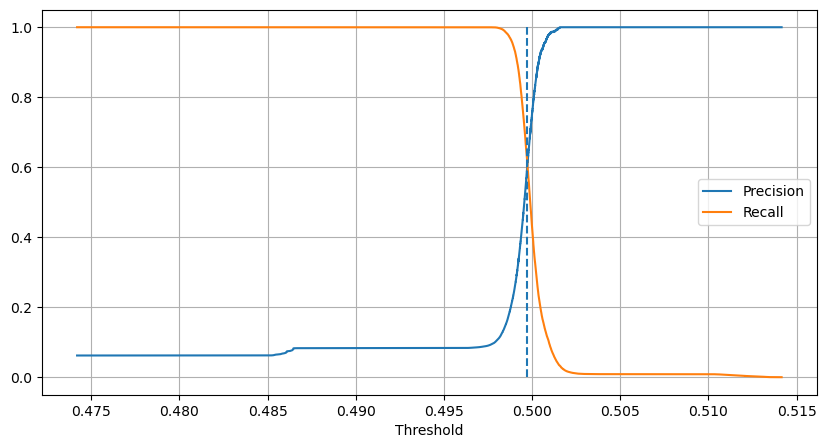

In [54]:
ada_model_v3 = AdaBoostClassifier(n_estimators=800,
                                  learning_rate=1,
                                  estimator=DecisionTreeClassifier(max_depth=1,
                                                                   min_samples_leaf=4,
                                                                   min_samples_split=2,
                                                                   max_leaf_nodes=3,
                                                                     random_state=42),
                                    random_state=7)

ada_model_v3.fit(X, y)

ada_model_v3_proba_train = ada_model_v3.predict_proba(X)[:, 1]

threshold_4 = find_threshold(ada_model_v3_proba_train, y)

confusion_matrix:
Accuracy: 82.43319099456707%
Recall: 93.43679275784028%
Precision: 25.24127691165553%


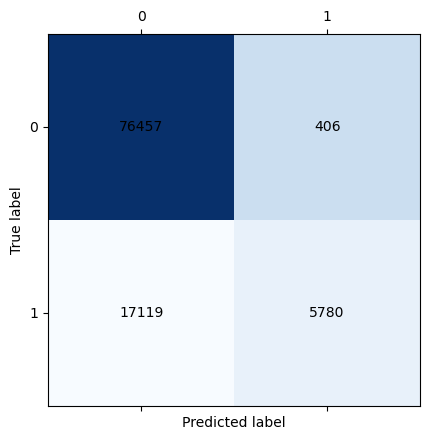

In [57]:
test_probs_v3 = ada_model_v3.predict_proba(X_test)[:, 1]

In [56]:
threshold_4

0.4997280997467035

confusion_matrix:
Accuracy: 91.00759808343858%
Recall: 82.54122211445198%
Precision: 39.28598907440178%


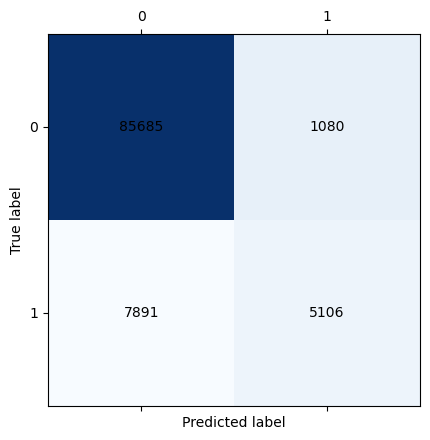

In [72]:
test_preds_v3 = (test_probs_v3 > .499356).astype(int)

get_metrics(y_test, test_preds_v3)

# Attempt 5 

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Tune all the parameters except for n_estimators

param_dist = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
                'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                'estimator__max_depth': [1],
                'estimator__min_samples_split': [2, 4, 6, 8],
                'estimator__min_samples_leaf': [1, 2, 4, 6, 8],
                'estimator': [DecisionTreeClassifier()],
                'estimator__max_leaf_nodes': [3,4,5,10]
                }

ada = AdaBoostClassifier(random_state=42)

ada_cv = RandomizedSearchCV(ada, param_dist, cv=2, scoring='roc_auc', n_iter=60, random_state=77, verbose=2, n_jobs=-1)

ada_cv.fit(X, y)

ada_cv.best_params_

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=5, estimator__min_samples_leaf=1, estimator__min_samples_split=6, learning_rate=0.05, n_estimators=700; total time= 2.4min
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=3, estimator__min_samples_leaf=6, estimator__min_samples_split=2, learning_rate=0.5, n_estimators=700; total time= 2.4min
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=4, estimator__min_samples_leaf=6, estimator__min_samples_split=8, learning_rate=0.1, n_estimators=700; total time= 2.4min
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, estimator__max_leaf_nodes=3, estimator__min_samples_leaf=6, estimator__min_samples_split=2, learning_rate=0.5, n_estimators=700; total time= 2.4min
[CV] END estimator=DecisionTreeClassifier(), estimator__max_depth=1, 

{'n_estimators': 900,
 'learning_rate': 1,
 'estimator__min_samples_split': 6,
 'estimator__min_samples_leaf': 1,
 'estimator__max_leaf_nodes': 3,
 'estimator__max_depth': 1,
 'estimator': DecisionTreeClassifier(max_depth=1, max_leaf_nodes=3, min_samples_split=6)}

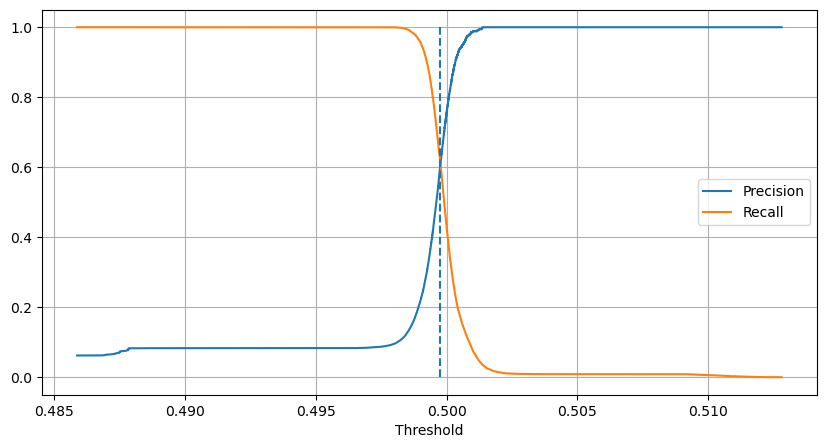

In [110]:
# Create a classifier with the best parameters
ada_model_v4 = AdaBoostClassifier(n_estimators=900,
                                  learning_rate=1,
                                  estimator=DecisionTreeClassifier(max_depth=1, 
                                                                   max_leaf_nodes=3, 
                                                                   min_samples_split=6,
                                                                   min_samples_leaf=1),
                                    random_state=7)

ada_model_v4.fit(X, y)

ada_model_v4_proba_train = ada_model_v4.predict_proba(X)[:, 1]

threshold_5 = find_threshold(ada_model_v4_proba_train, y)

In [111]:
test_probs_v5 = ada_model_v4.predict_proba(X_test)[:, 1]

confusion_matrix:
Accuracy: 90.89432850183437%
Recall: 82.94536049143227%
Precision: 38.98936170212766%


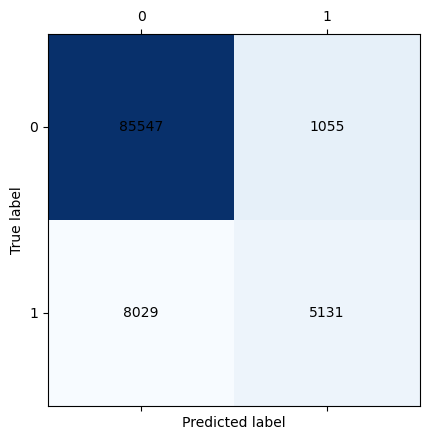

In [112]:
test_preds_v5 = (test_probs_v5 > .49942).astype(int)

get_metrics(y_test, test_preds_v5)

In [113]:
# Print the feature importances
feature_importances = pd.DataFrame(ada_model_v4.feature_importances_,
                                      index = X.columns,    
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
cap_gain,0.213333
cap_loss,0.204444
occ_code_det,0.090000
education,0.081111
age,0.053333
ind_code_det,0.046667
dividend,0.043333
tax_filer_stat,0.040000
weeks_worked,0.035556
wage_hr,0.023333


confusion_matrix:
Accuracy: 90.81609638988989%
Recall: 82.70877079631724%
Precision: 38.756433545261885%


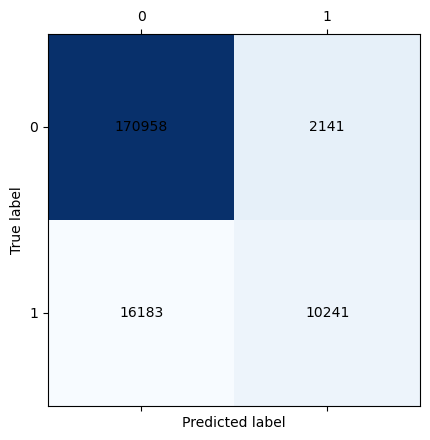

In [115]:
# Print the confusion matrix for ada_model_v4_proba_train
train_preds = (ada_model_v4_proba_train > .49942).astype(int)

get_metrics(y, train_preds)
